## Configuration Parameters

In [1]:
import sys
sys.path.append('/home/mohsen/kvcache/hira')
sys.path.append('/home/mohsen/kvcache/hira/tests/kv_sampling')

from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import pandas as pd
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

print("Libraries imported successfully!")

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Libraries imported successfully!


In [2]:
# ============================================================================
# CONFIGURATION PARAMETERS - EDIT THESE
# ============================================================================

# Data parameters
NUM_POINTS = 10_000       # Number of points in the space
DIMENSION = 128            # Dimension of the space
DISTRIBUTIONS = ['uniform', 'normal', 'mixture_gaussians', 'zipf', 'synthetic_lowrank', 'real']  # Distributions to test

# Mixture of Gaussians parameters (based on distribution_fitting_analysis.ipynb recommendations)
MIX_NUM_COMPONENTS = 10   # Number of Gaussian components (optimized from real data analysis)
# Component parameters from GMM fitted to real KV cache data:
MIX_GMM_WEIGHTS = np.array([0.1255, 0.2067, 0.0046, 0.1678, 0.0027, 0.0928, 0.0143, 0.3021, 0.0258, 0.0576])
MIX_GMM_WEIGHTS = MIX_GMM_WEIGHTS / MIX_GMM_WEIGHTS.sum()  # Normalize to ensure sum is exactly 1.0
MIX_GMM_MEANS = [1.3819, -0.9039, -12.4851, 0.6147, 10.9554, -1.9572, 4.2475, -0.0570, -3.3843, 2.4689]
MIX_GMM_STDS = [0.3879, 0.3699, 2.1610, 0.3008, 1.9482, 0.5171, 1.0753, 0.2514, 1.0471, 0.5737]

# Zipf parameters
ZIPF_ALPHA = 1.5          # Zipf exponent (higher = more skewed)

# Synthetic low-rank parameters
SYNTHETIC_RANK = 8        # Rank of low-rank structure
SYNTHETIC_SIGMA = 0.5     # Noise level

# Real data parameters
# REAL_DATA_PATH = '/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251217_002021.npz'
# REAL_DATA_PATH = '/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Llama-3.2-3B-Instruct_layer27_20251217_010209.npz'
REAL_DATA_PATH = '/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_qwen_Qwen2.5-7B-Instruct_layer27_20251217_010838.npz'
REAL_DATA_LAYER = 0       # Layer index to use (not needed for npz files)

# Ball parameters - k nearest neighbors
K_VALUES = [1, 2, 4, 8, 16]  # Different values of k to test

# Halfspace test parameters
NUM_HALFSPACES = 100      # Number of random halfspaces to test
TAU = 0.01  # Tau = percentage of points INSIDE each halfspace

# Device
DEVICE = 'cpu'  # 'cpu' or 'cuda'

# Output
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  Points: {NUM_POINTS}")
print(f"  Dimension: {DIMENSION}")
print(f"  Distributions: {DISTRIBUTIONS}")
print(f"  K values (nearest neighbors): {K_VALUES}")
print(f"  Halfspace tests: {NUM_HALFSPACES} halfspaces")
print(f"  Tau (% of points INSIDE halfspace): {TAU*100}%")
print(f"  Device: {DEVICE}")
print(f"  Figures directory: {FIGURES_DIR.resolve()}")


Configuration:
  Points: 10000
  Dimension: 128
  Distributions: ['uniform', 'normal', 'mixture_gaussians', 'zipf', 'synthetic_lowrank', 'real']
  K values (nearest neighbors): [1, 2, 4, 8, 16]
  Halfspace tests: 100 halfspaces
  Tau (% of points INSIDE halfspace): 1.0%
  Device: cpu
  Figures directory: /home/mohsen/kvcache/hira/tests/pruning/notebooks/figures


## Generate Points

In [3]:
def generate_points(distribution: str, num_points: int, dimension: int, seed: int = 42) -> torch.Tensor:
    """
    Generate points from different distributions.
    
    Args:
        distribution: Type of distribution ('uniform', 'normal', 'mixture_gaussians', 'zipf', 'synthetic_lowrank', 'real')
        num_points: Number of points
        dimension: Dimension of each point
        seed: Random seed
        
    Returns:
        Points [num_points, dimension] (NOT normalized)
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if distribution == 'normal':
        points = torch.randn(num_points, dimension)
        
    elif distribution == 'uniform':
        points = torch.rand(num_points, dimension) * 2 - 1  # Uniform in [-1, 1]
        
    elif distribution == 'mixture_gaussians':
        # Generate mixture of Gaussians using fitted parameters from real data
        points = torch.zeros(num_points, dimension)
        
        # Sample component assignments based on weights
        component_assignments = np.random.choice(
            MIX_NUM_COMPONENTS, 
            size=num_points, 
            p=MIX_GMM_WEIGHTS
        )
        
        # Generate points for each component
        for i in range(MIX_NUM_COMPONENTS):
            # Find indices assigned to this component
            component_mask = (component_assignments == i)
            n_points_in_component = component_mask.sum()
            
            if n_points_in_component > 0:
                # Generate points from this Gaussian component
                # Use the fitted mean and std for each dimension
                component_points = torch.randn(n_points_in_component, dimension) * MIX_GMM_STDS[i] + MIX_GMM_MEANS[i]
                points[component_mask] = component_points
            
    elif distribution == 'zipf':
        # Generate Zipf-distributed frequencies for dimensions
        # Then use those to weight random vectors
        points = torch.zeros(num_points, dimension)
        
        # Generate Zipf weights for each dimension
        ranks = torch.arange(1, dimension + 1, dtype=torch.float32)
        zipf_weights = 1.0 / (ranks ** ZIPF_ALPHA)
        zipf_weights = zipf_weights / zipf_weights.sum()  # Normalize
        
        # Generate points with Zipf-weighted dimensions
        for i in range(num_points):
            # Sample dimensions according to Zipf distribution
            random_values = torch.randn(dimension)
            points[i] = random_values * torch.sqrt(zipf_weights * dimension)
    
    elif distribution == 'synthetic_lowrank':
        # Generate low-rank structure with noise
        # k = s @ U.T + eps, where U is d x r, s is n x r, eps is noise
        U = torch.randn(dimension, SYNTHETIC_RANK)
        s = torch.randn(num_points, SYNTHETIC_RANK)
        eps = SYNTHETIC_SIGMA * torch.randn(num_points, dimension)
        points = s @ U.T + eps
    
    elif distribution == 'real':
        # Load real KV cache data from NPZ file
        print(f"  Loading real data from: {REAL_DATA_PATH}")
        data = np.load(REAL_DATA_PATH)
        keys = torch.from_numpy(data['keys']).float()
        
        # Subsample if needed
        if len(keys) > num_points:
            indices = torch.randperm(len(keys))[:num_points]
            keys = keys[indices]
        
        points = keys
        print(f"  Loaded {len(points)} real keys (dimension={points.shape[1]})")
            
    else:
        raise ValueError(f"Unknown distribution: {distribution}")
    
    # Do NOT normalize - keep points in their original space
    return points

# Generate points for all distributions
all_points = {}

for dist in DISTRIBUTIONS:
    print(f"\nGenerating {NUM_POINTS} points for {dist} distribution...")
    points = generate_points(dist, NUM_POINTS, DIMENSION)
    all_points[dist] = points
    print(f"  Shape: {points.shape}, Mean: {points.mean():.4f}, Std: {points.std():.4f}")

print(f"\nGenerated points for {len(all_points)} distributions")



Generating 10000 points for uniform distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0008, Std: 0.5772

Generating 10000 points for normal distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0004, Std: 1.0001

Generating 10000 points for mixture_gaussians distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0146, Std: 1.7523

Generating 10000 points for zipf distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0013, Std: 0.9994

Generating 10000 points for synthetic_lowrank distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0039, Std: 2.8996

Generating 10000 points for real distribution...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_qwen_Qwen2.5-7B-Instruct_layer27_20251217_010838.npz
  Loaded 10000 real keys (dimension=128)
  Shape: torch.Size([10000, 128]), Mean: -2.4827, Std: 40.6495

Generated points for 6 distributions


## Compute Ball Radii for K Nearest Neighbors

In [4]:
def compute_knn_ball_radii(points: torch.Tensor, k: int) -> torch.Tensor:
    """
    For each point, find the radius of the smallest ball that contains its k nearest neighbors.
    
    Args:
        points: Points [num_points, dim]
        k: Number of nearest neighbors
        
    Returns:
        Ball radii [num_points] - radius of ball containing k nearest neighbors
    """
    num_points = points.shape[0]
    
    # Compute pairwise distances
    # Using batched computation to avoid memory issues
    batch_size = 1000
    ball_radii = torch.zeros(num_points, dtype=torch.float32)
    
    print(f"Computing ball radii for k={k} nearest neighbors...")
    for i in tqdm(range(0, num_points, batch_size), leave=False):
        end_i = min(i + batch_size, num_points)
        batch_points = points[i:end_i]
        
        # Compute distances from batch to all points
        # dist[j, k] = ||points[i+j] - points[k]||
        dists = torch.cdist(batch_points, points)  # [batch_size, num_points]
        
        # For each point in batch, find k-th nearest neighbor distance
        # k+1 because the point itself is included (distance 0)
        kth_distances, _ = torch.topk(dists, k + 1, largest=False, dim=1)
        # The radius is the distance to the k-th nearest neighbor (last in sorted list)
        ball_radii[i:end_i] = kth_distances[:, -1]
    
    return ball_radii

# Compute ball radii for all distributions and k values
all_ball_radii = {}

for dist in DISTRIBUTIONS:
    print(f"\n{'='*60}")
    print(f"Processing {dist} distribution")
    print('='*60)
    
    points = all_points[dist]
    all_ball_radii[dist] = {}
    
    for k in K_VALUES:
        ball_radii = compute_knn_ball_radii(points, k)
        all_ball_radii[dist][k] = ball_radii
        
        print(f"  k={k}: Mean radius = {ball_radii.mean():.4f}, Std = {ball_radii.std():.4f}")

print(f"\n✓ Computed ball radii for {len(DISTRIBUTIONS)} distributions and {len(K_VALUES)} k values")


Processing uniform distribution
Computing ball radii for k=1 nearest neighbors...


  k=1: Mean radius = 7.4426, Std = 0.2139
Computing ball radii for k=2 nearest neighbors...


  k=2: Mean radius = 7.5598, Std = 0.1863
Computing ball radii for k=4 nearest neighbors...


  k=4: Mean radius = 7.6640, Std = 0.1740
Computing ball radii for k=8 nearest neighbors...


  k=8: Mean radius = 7.7653, Std = 0.1694
Computing ball radii for k=16 nearest neighbors...


  k=16: Mean radius = 7.8677, Std = 0.1672

Processing normal distribution
Computing ball radii for k=1 nearest neighbors...


  k=1: Mean radius = 12.7185, Std = 0.5172
Computing ball radii for k=2 nearest neighbors...


  k=2: Mean radius = 12.9237, Std = 0.4852
Computing ball radii for k=4 nearest neighbors...


  k=4: Mean radius = 13.1048, Std = 0.4732
Computing ball radii for k=8 nearest neighbors...


  k=8: Mean radius = 13.2804, Std = 0.4696
Computing ball radii for k=16 nearest neighbors...


  k=16: Mean radius = 13.4603, Std = 0.4684

Processing mixture_gaussians distribution
Computing ball radii for k=1 nearest neighbors...


  k=1: Mean radius = 5.1731, Std = 3.1864
Computing ball radii for k=2 nearest neighbors...


  k=2: Mean radius = 5.2652, Std = 3.2496
Computing ball radii for k=4 nearest neighbors...


  k=4: Mean radius = 5.3520, Std = 3.3211
Computing ball radii for k=8 nearest neighbors...


  k=8: Mean radius = 5.4388, Std = 3.3967
Computing ball radii for k=16 nearest neighbors...


  k=16: Mean radius = 5.5327, Std = 3.4971

Processing zipf distribution
Computing ball radii for k=1 nearest neighbors...


  k=1: Mean radius = 7.1025, Std = 0.5905
Computing ball radii for k=2 nearest neighbors...


  k=2: Mean radius = 7.3517, Std = 0.5854
Computing ball radii for k=4 nearest neighbors...


  k=4: Mean radius = 7.5984, Std = 0.6053
Computing ball radii for k=8 nearest neighbors...


  k=8: Mean radius = 7.8498, Std = 0.6378
Computing ball radii for k=16 nearest neighbors...


  k=16: Mean radius = 8.1237, Std = 0.6814

Processing synthetic_lowrank distribution
Computing ball radii for k=1 nearest neighbors...


  k=1: Mean radius = 14.2064, Std = 2.7868
Computing ball radii for k=2 nearest neighbors...


  k=2: Mean radius = 15.4342, Std = 2.8856
Computing ball radii for k=4 nearest neighbors...


  k=4: Mean radius = 16.6508, Std = 3.0161
Computing ball radii for k=8 nearest neighbors...


  k=8: Mean radius = 17.9440, Std = 3.2013
Computing ball radii for k=16 nearest neighbors...


  k=16: Mean radius = 19.3392, Std = 3.4067

Processing real distribution
Computing ball radii for k=1 nearest neighbors...


  k=1: Mean radius = 2.4239, Std = 3.1272
Computing ball radii for k=2 nearest neighbors...


  k=2: Mean radius = 2.7787, Std = 3.4030
Computing ball radii for k=4 nearest neighbors...


  k=4: Mean radius = 3.0884, Std = 3.6446
Computing ball radii for k=8 nearest neighbors...


  k=8: Mean radius = 3.4486, Std = 3.8728
Computing ball radii for k=16 nearest neighbors...


  k=16: Mean radius = 4.0415, Std = 4.0106

✓ Computed ball radii for 6 distributions and 5 k values


## Visualize Ball Radius Distribution

/tmp/ipykernel_3228753/1202097478.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_3228753/1202097478.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_3228753/1202097478.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_3228753/1202097478.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for 

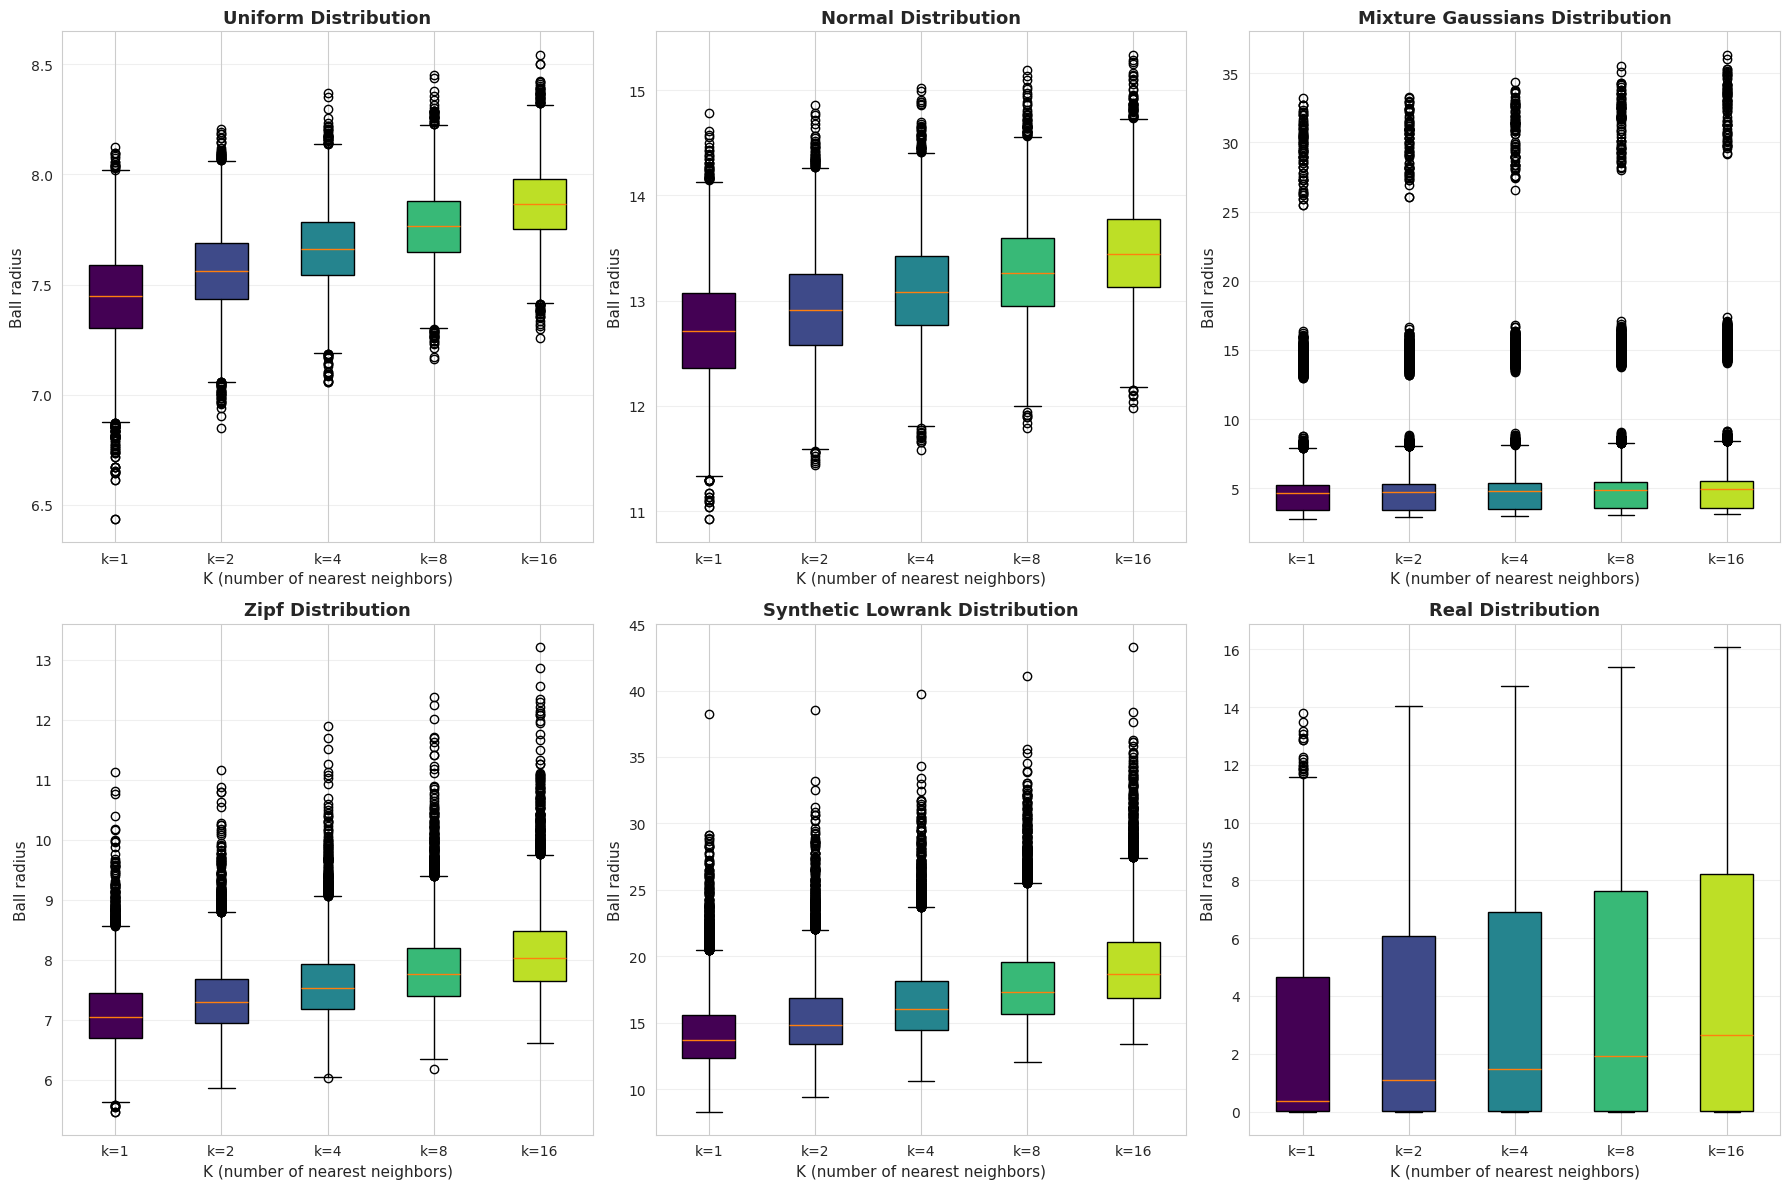

In [5]:
# Plot 1: Histogram of ball radii for each distribution (select middle k value)
middle_k_idx = len(K_VALUES) // 2
selected_k = K_VALUES[middle_k_idx]

num_dists = len(DISTRIBUTIONS)
# fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# axes = axes.flatten()

# for idx, dist in enumerate(DISTRIBUTIONS):
#     ax = axes[idx]
#     ball_radii = all_ball_radii[dist][selected_k]
    
#     ax.hist(ball_radii.numpy(), bins=50, alpha=0.7, edgecolor='black', color='steelblue')
#     ax.axvline(ball_radii.mean(), color='red', linestyle='--', linewidth=2, 
#                label=f'Mean: {ball_radii.mean():.4f}')
#     ax.axvline(ball_radii.median(), color='green', linestyle='--', linewidth=2, 
#                label=f'Median: {ball_radii.median():.4f}')
#     ax.set_xlabel('Ball radius', fontsize=11)
#     ax.set_ylabel('Frequency', fontsize=11)
#     ax.set_title(f'{dist.replace("_", " ").title()} (k={selected_k})', fontsize=13, fontweight='bold')
#     ax.legend(fontsize=10)
#     ax.grid(True, alpha=0.3)

# # Hide extra subplot if odd number of distributions
# if num_dists < len(axes):
#     for idx in range(num_dists, len(axes)):
#         axes[idx].axis('off')

# plt.tight_layout()
# # fig.savefig(FIGURES_DIR / f'ball_radius_distributions_k{selected_k}.png', dpi=300, bbox_inches='tight')
# plt.show()

# Plot 2: Box plot comparing k values for each distribution
num_dists = len(DISTRIBUTIONS)
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
axes2 = axes2.flatten()

for idx, dist in enumerate(DISTRIBUTIONS):
    ax = axes2[idx]
    
    data_to_plot = [all_ball_radii[dist][k].numpy() for k in K_VALUES]
    labels = [f'k={k}' for k in K_VALUES]
    
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    
    # Color boxes
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(K_VALUES)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xlabel('K (number of nearest neighbors)', fontsize=11)
    ax.set_ylabel('Ball radius', fontsize=11)
    ax.set_title(f'{dist.replace("_", " ").title()} Distribution', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Hide extra subplot if odd number of distributions
if num_dists < len(axes2):
    for idx in range(num_dists, len(axes2)):
        axes2[idx].axis('off')

plt.tight_layout()
# fig2.savefig(FIGURES_DIR / 'ball_radius_comparison_all_dists.png', dpi=300, bbox_inches='tight')
plt.show()

## Generate Random Halfspaces

In [6]:
def generate_random_unit_vector(dim: int, device: str = 'cpu') -> torch.Tensor:
    """Generate a random unit vector."""
    v = torch.randn(dim, device=torch.device(device))
    return v / torch.norm(v)

def compute_threshold_for_tau(points: torch.Tensor, q: torch.Tensor, tau: float) -> float:
    """
    Compute threshold such that tau percentage of points are INSIDE the halfspace.
    
    The halfspace is defined as: q·x >= threshold
    
    Args:
        points: Points [num_points, dim]
        q: Unit query vector [dim]
        tau: Percentage of points to be INSIDE halfspace (0-1)
              e.g., tau=0.01 means 1% of points satisfy q·x >= threshold
    
    Returns:
        Threshold value such that exactly tau fraction of points have q·x >= threshold
    """
    # Compute dot products q·x for all points
    dots = torch.matmul(points, q)
    
    # Find threshold at (1-tau) percentile
    # If tau=0.01, we want the top 1% of points, so we use the 99th percentile
    percentile_idx = int((1 - tau) * len(dots))
    sorted_dots, _ = torch.sort(dots)
    threshold = sorted_dots[percentile_idx].item()
    
    return threshold

# Generate random halfspaces
print(f"Generating {NUM_HALFSPACES} random halfspaces...")
random_queries = []
for i in range(NUM_HALFSPACES):
    q = generate_random_unit_vector(DIMENSION, DEVICE)
    random_queries.append(q)

print(f"Generated {len(random_queries)} random unit vectors")
print(f"\nNote: tau={TAU} means {TAU*100}% of points will be INSIDE each halfspace")

Generating 100 random halfspaces...
Generated 100 random unit vectors

Note: tau=0.01 means 1.0% of points will be INSIDE each halfspace


## Halfspace Intersection Analysis

In [7]:
def analyze_ball_halfspace_intersection(
    ball_centers: torch.Tensor,
    ball_radii: torch.Tensor,
    q: torch.Tensor,
    threshold: float
) -> Tuple[int, int, int]:
    """
    Analyze intersection of balls with a halfspace.
    
    The halfspace is defined as: q·x >= threshold
    
    Args:
        ball_centers: Centers of balls [num_balls, dim]
        ball_radii: Radius of each ball [num_balls]
        q: Unit query vector defining halfspace [dim]
        threshold: Threshold for halfspace (q·x >= threshold means INSIDE)
        
    Returns:
        - Number of balls completely inside halfspace (q·c >= threshold + radius)
        - Number of balls intersecting the hyperplane (|q·c - threshold| < radius)
        - Number of balls completely outside halfspace (q·c <= threshold - radius)
    """
    # Compute signed distance from ball center to hyperplane
    # Hyperplane equation: q·x = threshold
    # Signed distance from center c: q·c - threshold
    center_dots = torch.matmul(ball_centers, q)
    signed_distances = center_dots - threshold
    
    # A ball is completely INSIDE the halfspace if:
    # The farthest point from center (in direction -q) is still inside
    # q·c - radius >= threshold  =>  q·c >= threshold + radius
    completely_inside = (signed_distances >= ball_radii).sum().item()
    
    # A ball is completely OUTSIDE the halfspace if:
    # The farthest point from center (in direction +q) is still outside
    # q·c + radius <= threshold  =>  q·c <= threshold - radius
    completely_outside = (signed_distances <= -ball_radii).sum().item()
    
    # A ball INTERSECTS the hyperplane if:
    # The hyperplane passes through the ball
    # |q·c - threshold| < radius
    intersecting = (torch.abs(signed_distances) < ball_radii).sum().item()
    
    return completely_inside, intersecting, completely_outside

# Run intersection analysis for all distributions and k values
print("Running halfspace intersection analysis...")
print(f"For each halfspace, tau={TAU*100}% of POINTS are inside (q·x >= threshold)\n")

all_results = {}

for dist in DISTRIBUTIONS:
    print(f"\n{'='*60}")
    print(f"Testing {dist} distribution")
    print('='*60)
    
    points = all_points[dist]
    all_results[dist] = {}
    
    for k in K_VALUES:
        print(f"\n  k={k}")
        ball_radii = all_ball_radii[dist][k]
        results = {'inside': [], 'intersecting': [], 'outside': []}
        
        for q in tqdm(random_queries, desc=f"  tau={TAU*100:.0f}% points inside", leave=False):
            # Compute threshold for this tau
            threshold = compute_threshold_for_tau(points, q, TAU)
            
            # Analyze ball-halfspace intersection
            inside, intersecting, outside = analyze_ball_halfspace_intersection(
                points, ball_radii, q, threshold
            )
            
            results['inside'].append(inside)
            results['intersecting'].append(intersecting)
            results['outside'].append(outside)
        
        all_results[dist][k] = results

print("\n" + "="*60)
print("Analysis complete for all distributions and k values!")
print("="*60)

Running halfspace intersection analysis...
For each halfspace, tau=1.0% of POINTS are inside (q·x >= threshold)


Testing uniform distribution

  k=1



  k=2



  k=4



  k=8



  k=16



Testing normal distribution

  k=1



  k=2



  k=4



  k=8



  k=16



Testing mixture_gaussians distribution

  k=1



  k=2



  k=4



  k=8



  k=16



Testing zipf distribution

  k=1



  k=2



  k=4



  k=8



  k=16



Testing synthetic_lowrank distribution

  k=1



  k=2



  k=4



  k=8



  k=16



Testing real distribution

  k=1



  k=2



  k=4



  k=8



  k=16



Analysis complete for all distributions and k values!


## Compute Statistics

In [8]:
# Compute statistics for all distributions and k values
all_stats = []

for dist in DISTRIBUTIONS:
    for k in K_VALUES:
        results = all_results[dist][k]
        
        inside = results['inside']
        intersecting = results['intersecting']
        outside = results['outside']
        
        all_stats.append({
            'Distribution': dist,
            'K': k,
            'Mean Inside': np.mean(inside),
            'Std Inside': np.std(inside),
            'Mean Intersecting': np.mean(intersecting),
            'Std Intersecting': np.std(intersecting),
            'Mean Outside': np.mean(outside),
            'Std Outside': np.std(outside),
        })

stats_df = pd.DataFrame(all_stats)

print(f"\n{'='*80}")
print(f"Statistics for tau={TAU*100}% of points inside halfspace:")
print('='*80)

# Display statistics for each distribution
for dist in DISTRIBUTIONS:
    print(f"\n{dist.upper()} distribution:")
    print('-'*80)
    dist_stats = stats_df[stats_df['Distribution'] == dist].drop('Distribution', axis=1)
    print(dist_stats.to_string(index=False))
    print()


Statistics for tau=1.0% of points inside halfspace:

UNIFORM distribution:
--------------------------------------------------------------------------------
 K  Mean Inside  Std Inside  Mean Intersecting  Std Intersecting  Mean Outside  Std Outside
 1          0.0         0.0            10000.0               0.0           0.0          0.0
 2          0.0         0.0            10000.0               0.0           0.0          0.0
 4          0.0         0.0            10000.0               0.0           0.0          0.0
 8          0.0         0.0            10000.0               0.0           0.0          0.0
16          0.0         0.0            10000.0               0.0           0.0          0.0


NORMAL distribution:
--------------------------------------------------------------------------------
 K  Mean Inside  Std Inside  Mean Intersecting  Std Intersecting  Mean Outside  Std Outside
 1          0.0         0.0            10000.0               0.0           0.0          0.0
 2 

## Visualization

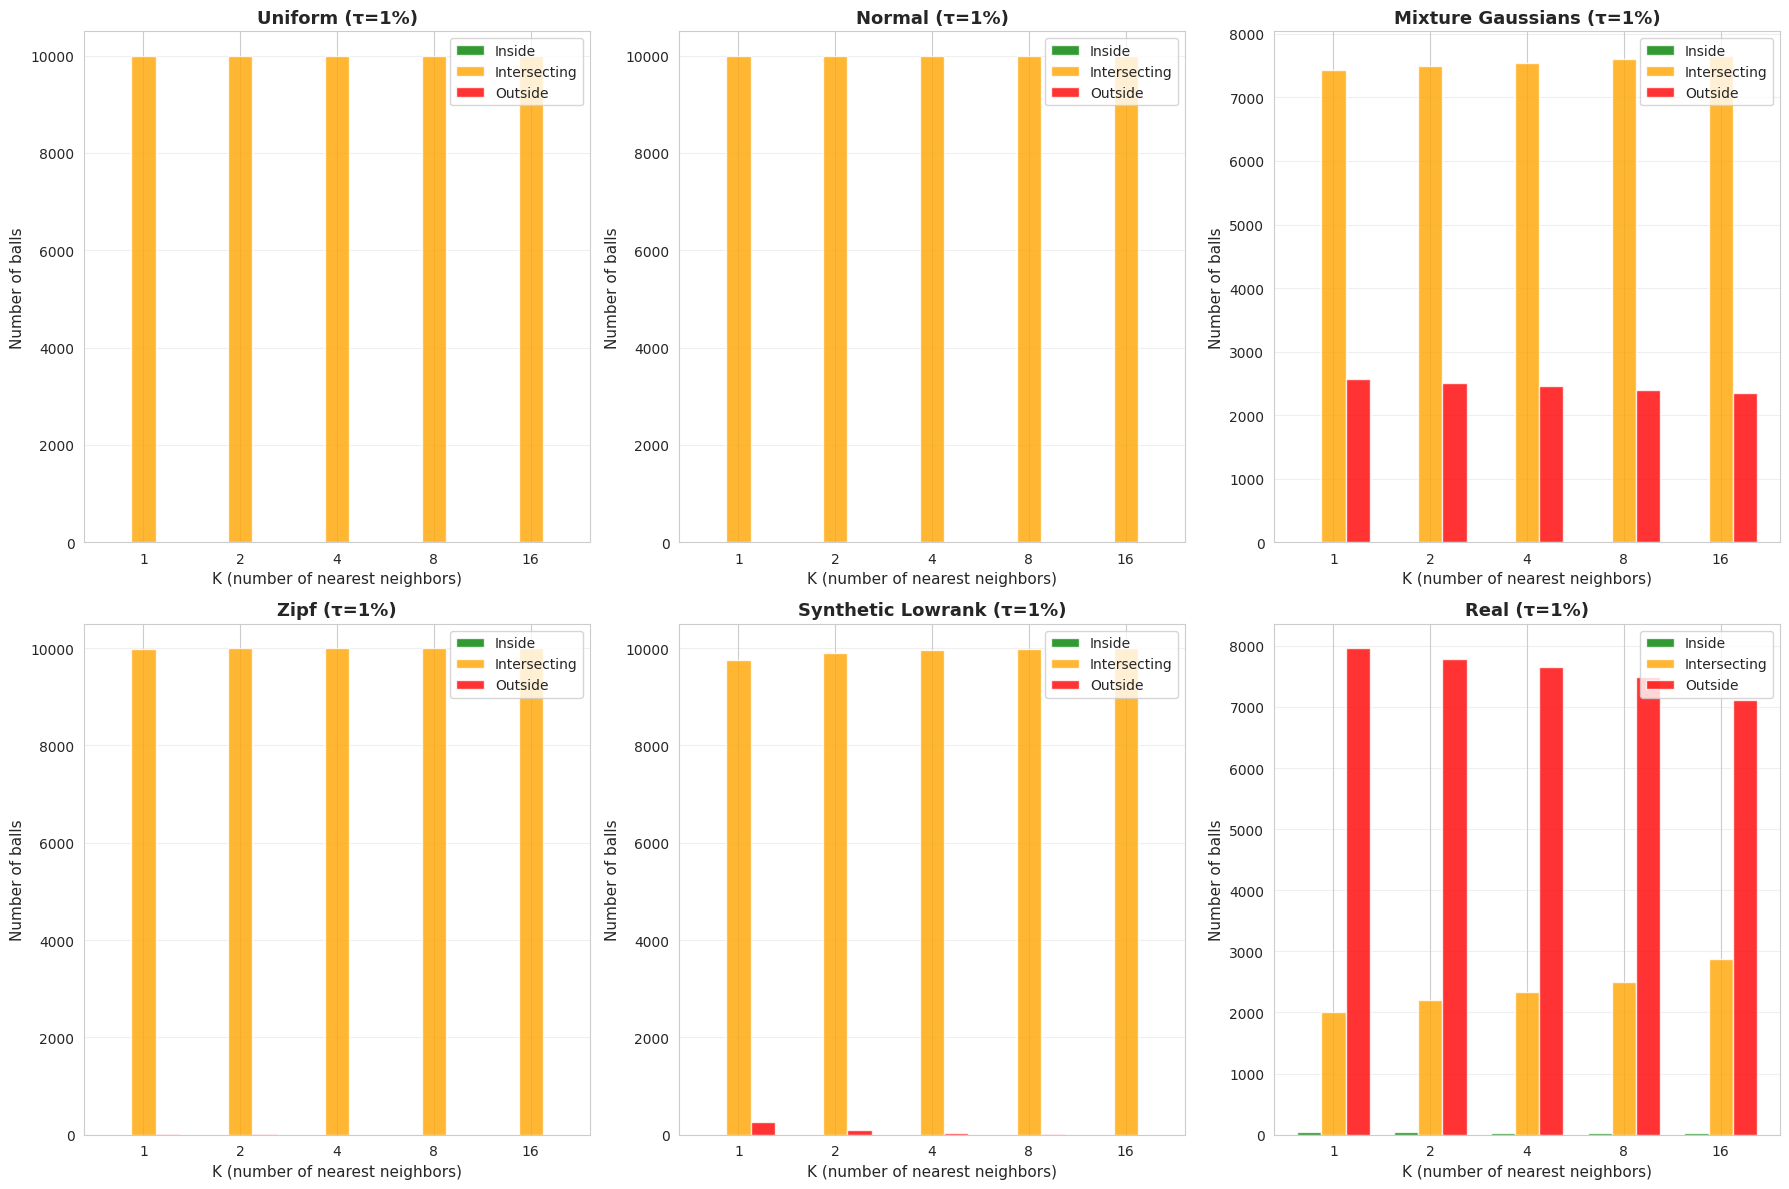

In [9]:
# Plot: Comparison across k values for each distribution
num_dists = len(DISTRIBUTIONS)
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
axes2 = axes2.flatten()

for idx, dist in enumerate(DISTRIBUTIONS):
    ax = axes2[idx]
    
    inside_vals = [np.mean(all_results[dist][k]['inside']) for k in K_VALUES]
    intersecting_vals = [np.mean(all_results[dist][k]['intersecting']) for k in K_VALUES]
    outside_vals = [np.mean(all_results[dist][k]['outside']) for k in K_VALUES]
    
    x = np.arange(len(K_VALUES))
    width = 0.25
    
    bars1 = ax.bar(x - width, inside_vals, width, label='Inside', color='green', alpha=0.8)
    bars2 = ax.bar(x, intersecting_vals, width, label='Intersecting', color='orange', alpha=0.8)
    bars3 = ax.bar(x + width, outside_vals, width, label='Outside', color='red', alpha=0.8)
    
    ax.set_xlabel('K (number of nearest neighbors)', fontsize=11)
    ax.set_ylabel('Number of balls', fontsize=11)
    ax.set_title(f'{dist.replace("_", " ").title()} (τ={TAU*100:.0f}%)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{k}' for k in K_VALUES])
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

# Hide extra subplot if odd number of distributions
if num_dists < len(axes2):
    for idx in range(num_dists, len(axes2)):
        axes2[idx].axis('off')

plt.tight_layout()
# fig2.savefig(FIGURES_DIR / f'ball_distribution_comparison_tau{TAU}.png', dpi=300, bbox_inches='tight')
plt.show()